In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split

%matplotlib inline

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data preprocessing

In [2]:
df = pd.read_csv('./train.csv')
df = df.drop('PassengerId', 1)
df = df.drop('Name', 1)
df = df.drop('Ticket', 1)
df = df.drop('Cabin', 1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
encode_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for enc in encode_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,38.0,71.2833,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,35.0,8.0500,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1


In [4]:
df.describe()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,32.204208,0.242424,0.206510,0.551066,0.352413,0.647587,0.682379,0.234568,...,0.760943,0.132435,0.089787,0.005612,0.004489,0.005612,0.001122,0.188552,0.086420,0.722783
std,0.486592,14.526497,49.693429,0.428790,0.405028,0.497665,0.477990,0.477990,0.465813,0.423966,...,0.426747,0.339154,0.286037,0.074743,0.066890,0.074743,0.033501,0.391372,0.281141,0.447876
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
real_features = ['Age', 'Fare']
cat_features = list(set(df.columns.values.tolist()) - set(real_features) )
cat_features.remove('Survived')
print (cat_features)

['Embarked_C', 'Parch_4', 'Pclass_3', 'Parch_2', 'Parch_0', 'SibSp_8', 'Parch_1', 'Pclass_1', 'SibSp_1', 'Parch_3', 'Parch_6', 'SibSp_3', 'Embarked_Q', 'SibSp_0', 'SibSp_4', 'Parch_5', 'SibSp_5', 'Sex_female', 'Pclass_2', 'Embarked_S', 'SibSp_2', 'Sex_male']


In [6]:
print (df.shape)

(891, 25)


In [7]:
df['Age'] = df['Age'].fillna(0)

In [8]:
y = df['Survived'].to_numpy()
df = df.drop('Survived', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [22.    7.25] 
X_cat: [0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1] 
y: 0 


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)

In [10]:
(X_train_real, X_test_real, X_train_cat, X_test_cat, 
 y_train, y_test)= train_test_split(X_real_scaled, X_cat, y, test_size=0.1, random_state=0)
print (X_train_real.shape, X_test_real.shape)
print (X_train_cat.shape, X_test_cat.shape)

(801, 2) (90, 2)
(801, 22) (90, 22)


In [11]:
selected_features = (0, 1, 2, 5, 7, 9, 10, 12, 14, 16, 17, 18, 19, 21, 22)

In [12]:
X_train = np.hstack((X_train_real, X_train_cat))
X_test = np.hstack((X_test_real, X_test_cat))

X_train = X_train[:,selected_features]
X_test = X_test[:,selected_features]

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

print (X_train.shape, X_test.shape)

torch.Size([801, 15]) torch.Size([90, 15])


## Neural network

In [13]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.ReLU):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
            layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [14]:
def correct_vals(output, target):
    vals = []
    for out in output:
        out = out.item()
        if out >= 0.5:
            vals.append(1)
        else:
            vals.append(0)   
    vals = torch.Tensor(vals)
    correct = (vals == target).sum().item()         
    return correct

In [15]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
               
        self.fc = FullyConnected([15, 64, 1], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.criterion = nn.BCELoss()
           
    def forward(self, x):        
        out = self.fc(x)
        return out.squeeze(1)
    
    def loss(self, output, target, **kwargs):          
        self._loss = self.criterion(output, target)
        self._correct = correct_vals(output, target)   
        
        return self._loss

In [16]:
def train(epoch, models, log=None):
    train_size = len(X_train)
    for batch_idx, (data, target) in enumerate(loader(X_train, y_train)):
        for model in models.values():                             
            model.optim.zero_grad()            
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [17]:
def test(models, log=None):
    test_size = len(X_test)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader(X_test, y_test):
            output = {k: m(data) for k, m in models.items()}           
            for k, m in models.items():     
                #print (output[k].shape, target.shape)
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss                
                correct[k] += correct_vals(output[k], target)
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [18]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
 
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [19]:
def loader(x, y, batch_size=16):    
    for i in range(0, x.shape[0] - 1, batch_size):
        data = x[i:i+batch_size]
        if data.shape[0] == batch_size:            
            targets = y[i:i+batch_size]

            yield data, targets

In [20]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

print (models['bn'])

Net(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=15, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (criterion): BCELoss()
)


In [21]:
for epoch in range(1, 201):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_log)

Train Epoch: 1 [0/801 (0%)]	Losses bn: 0.710103 drop: 0.718825 plain: 0.662790
Train Epoch: 1 [800/801 (6%)]	Losses bn: 0.702312 drop: 0.701909 plain: 0.752292
Test set:
bn: Loss: 0.0390	Accuracy: 31.0/90 (34%)
drop: Loss: 0.0389	Accuracy: 39.0/90 (43%)
plain: Loss: 0.0377	Accuracy: 48.0/90 (53%)

Train Epoch: 2 [0/801 (0%)]	Losses bn: 0.699558 drop: 0.716243 plain: 0.654754
Train Epoch: 2 [800/801 (6%)]	Losses bn: 0.702253 drop: 0.715166 plain: 0.748710
Test set:
bn: Loss: 0.0386	Accuracy: 46.0/90 (51%)
drop: Loss: 0.0386	Accuracy: 44.0/90 (49%)
plain: Loss: 0.0373	Accuracy: 49.0/90 (54%)

Train Epoch: 3 [0/801 (0%)]	Losses bn: 0.690652 drop: 0.681611 plain: 0.647797
Train Epoch: 3 [800/801 (6%)]	Losses bn: 0.702034 drop: 0.740579 plain: 0.745101
Test set:
bn: Loss: 0.0383	Accuracy: 50.0/90 (56%)
drop: Loss: 0.0383	Accuracy: 46.0/90 (51%)
plain: Loss: 0.0370	Accuracy: 51.0/90 (57%)

Train Epoch: 4 [0/801 (0%)]	Losses bn: 0.682282 drop: 0.697847 plain: 0.640982
Train Epoch: 4 [800/801 

Train Epoch: 30 [800/801 (6%)]	Losses bn: 0.587904 drop: 0.669003 plain: 0.598128
Test set:
bn: Loss: 0.0293	Accuracy: 61.0/90 (68%)
drop: Loss: 0.0314	Accuracy: 58.0/90 (64%)
plain: Loss: 0.0286	Accuracy: 63.0/90 (70%)

Train Epoch: 31 [0/801 (0%)]	Losses bn: 0.508668 drop: 0.544973 plain: 0.487865
Train Epoch: 31 [800/801 (6%)]	Losses bn: 0.582498 drop: 0.688604 plain: 0.593171
Test set:
bn: Loss: 0.0290	Accuracy: 62.0/90 (69%)
drop: Loss: 0.0311	Accuracy: 58.0/90 (64%)
plain: Loss: 0.0284	Accuracy: 63.0/90 (70%)

Train Epoch: 32 [0/801 (0%)]	Losses bn: 0.504055 drop: 0.495612 plain: 0.484065
Train Epoch: 32 [800/801 (6%)]	Losses bn: 0.577250 drop: 0.643697 plain: 0.588339
Test set:
bn: Loss: 0.0287	Accuracy: 63.0/90 (70%)
drop: Loss: 0.0309	Accuracy: 59.0/90 (66%)
plain: Loss: 0.0281	Accuracy: 63.0/90 (70%)

Train Epoch: 33 [0/801 (0%)]	Losses bn: 0.499617 drop: 0.508087 plain: 0.480408
Train Epoch: 33 [800/801 (6%)]	Losses bn: 0.572143 drop: 0.607284 plain: 0.583655
Test set:
bn: L

Train Epoch: 58 [800/801 (6%)]	Losses bn: 0.492375 drop: 0.547626 plain: 0.506712
Test set:
bn: Loss: 0.0246	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0263	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0244	Accuracy: 64.0/90 (71%)

Train Epoch: 59 [0/801 (0%)]	Losses bn: 0.433640 drop: 0.522137 plain: 0.427720
Train Epoch: 59 [800/801 (6%)]	Losses bn: 0.490588 drop: 0.635830 plain: 0.504976
Test set:
bn: Loss: 0.0245	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0262	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0243	Accuracy: 64.0/90 (71%)

Train Epoch: 60 [0/801 (0%)]	Losses bn: 0.432417 drop: 0.467448 plain: 0.426854
Train Epoch: 60 [800/801 (6%)]	Losses bn: 0.488837 drop: 0.579136 plain: 0.503312
Test set:
bn: Loss: 0.0244	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0261	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0242	Accuracy: 64.0/90 (71%)

Train Epoch: 61 [0/801 (0%)]	Losses bn: 0.431279 drop: 0.494331 plain: 0.426030
Train Epoch: 61 [800/801 (6%)]	Losses bn: 0.487162 drop: 0.515230 plain: 0.501693
Test set:
bn: L

Train Epoch: 86 [800/801 (6%)]	Losses bn: 0.463856 drop: 0.521696 plain: 0.475056
Test set:
bn: Loss: 0.0231	Accuracy: 63.0/90 (70%)
drop: Loss: 0.0241	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0229	Accuracy: 64.0/90 (71%)

Train Epoch: 87 [0/801 (0%)]	Losses bn: 0.413951 drop: 0.464760 plain: 0.413583
Train Epoch: 87 [800/801 (6%)]	Losses bn: 0.463260 drop: 0.528657 plain: 0.474411
Test set:
bn: Loss: 0.0231	Accuracy: 63.0/90 (70%)
drop: Loss: 0.0241	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0228	Accuracy: 64.0/90 (71%)

Train Epoch: 88 [0/801 (0%)]	Losses bn: 0.413526 drop: 0.422775 plain: 0.413275
Train Epoch: 88 [800/801 (6%)]	Losses bn: 0.462703 drop: 0.524347 plain: 0.473778
Test set:
bn: Loss: 0.0230	Accuracy: 63.0/90 (70%)
drop: Loss: 0.0240	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0228	Accuracy: 64.0/90 (71%)

Train Epoch: 89 [0/801 (0%)]	Losses bn: 0.413091 drop: 0.443479 plain: 0.412971
Train Epoch: 89 [800/801 (6%)]	Losses bn: 0.462164 drop: 0.510289 plain: 0.473171
Test set:
bn: L

Train Epoch: 114 [800/801 (6%)]	Losses bn: 0.453566 drop: 0.439762 plain: 0.462597
Test set:
bn: Loss: 0.0225	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0231	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0222	Accuracy: 64.0/90 (71%)

Train Epoch: 115 [0/801 (0%)]	Losses bn: 0.403203 drop: 0.464342 plain: 0.406022
Train Epoch: 115 [800/801 (6%)]	Losses bn: 0.453351 drop: 0.464544 plain: 0.462328
Test set:
bn: Loss: 0.0225	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0231	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0222	Accuracy: 64.0/90 (71%)

Train Epoch: 116 [0/801 (0%)]	Losses bn: 0.402845 drop: 0.373020 plain: 0.405747
Train Epoch: 116 [800/801 (6%)]	Losses bn: 0.453167 drop: 0.610368 plain: 0.462057
Test set:
bn: Loss: 0.0225	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0231	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0222	Accuracy: 64.0/90 (71%)

Train Epoch: 117 [0/801 (0%)]	Losses bn: 0.402476 drop: 0.389454 plain: 0.405473
Train Epoch: 117 [800/801 (6%)]	Losses bn: 0.452983 drop: 0.476819 plain: 0.461812
Test set

Train Epoch: 143 [800/801 (6%)]	Losses bn: 0.449958 drop: 0.501172 plain: 0.457497
Test set:
bn: Loss: 0.0223	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0226	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0219	Accuracy: 65.0/90 (72%)

Train Epoch: 144 [0/801 (0%)]	Losses bn: 0.393023 drop: 0.435956 plain: 0.398112
Train Epoch: 144 [800/801 (6%)]	Losses bn: 0.449907 drop: 0.499148 plain: 0.457379
Test set:
bn: Loss: 0.0223	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0226	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0219	Accuracy: 65.0/90 (72%)

Train Epoch: 145 [0/801 (0%)]	Losses bn: 0.392648 drop: 0.486108 plain: 0.397855
Train Epoch: 145 [800/801 (6%)]	Losses bn: 0.449891 drop: 0.482350 plain: 0.457265
Test set:
bn: Loss: 0.0223	Accuracy: 64.0/90 (71%)
drop: Loss: 0.0226	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0219	Accuracy: 65.0/90 (72%)

Train Epoch: 146 [0/801 (0%)]	Losses bn: 0.392278 drop: 0.384759 plain: 0.397611
Train Epoch: 146 [800/801 (6%)]	Losses bn: 0.449854 drop: 0.462118 plain: 0.457174
Test set

Train Epoch: 172 [800/801 (6%)]	Losses bn: 0.449434 drop: 0.505212 plain: 0.455094
Test set:
bn: Loss: 0.0222	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0224	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0218	Accuracy: 65.0/90 (72%)

Train Epoch: 173 [0/801 (0%)]	Losses bn: 0.382496 drop: 0.366991 plain: 0.391082
Train Epoch: 173 [800/801 (6%)]	Losses bn: 0.449435 drop: 0.484547 plain: 0.455044
Test set:
bn: Loss: 0.0222	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0224	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0218	Accuracy: 65.0/90 (72%)

Train Epoch: 174 [0/801 (0%)]	Losses bn: 0.382133 drop: 0.406129 plain: 0.390847
Train Epoch: 174 [800/801 (6%)]	Losses bn: 0.449446 drop: 0.542481 plain: 0.455032
Test set:
bn: Loss: 0.0222	Accuracy: 65.0/90 (72%)
drop: Loss: 0.0223	Accuracy: 64.0/90 (71%)
plain: Loss: 0.0218	Accuracy: 65.0/90 (72%)

Train Epoch: 175 [0/801 (0%)]	Losses bn: 0.381773 drop: 0.389832 plain: 0.390604
Train Epoch: 175 [800/801 (6%)]	Losses bn: 0.449467 drop: 0.467635 plain: 0.454984
Test set

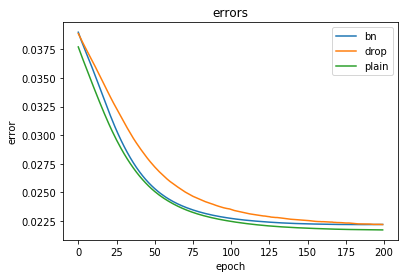

In [22]:
plot_graphs(test_log, 'loss')

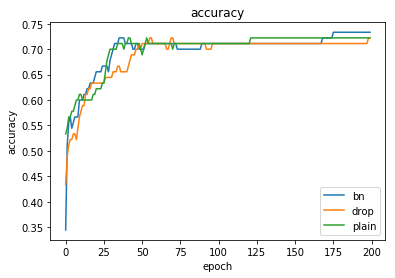

In [23]:
plot_graphs(test_log, 'accuracy')